## Технологии машинного обучения

## Практическая 4. Обучение без учителя
### Кирилл Захаров

### О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к текстовым данным (тематическое моделирование) 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. 


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0xFFFFFFF)

## Тематическое моделирование текстов

В этой работе мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [2]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
1289       politics  394.txt  Economy focus for election battle   
1872           tech  049.txt            Domain system scam fear   
1044       politics  149.txt   Blair returns from peace mission   
654   entertainment  145.txt   Sir Paul rocks Super Bowl crowds   
134        business  135.txt   Feta cheese battle reaches court   

                                                content  
1289   Britain's economic future will be at the hear...  
1872   A system to make it easier to create website ...  
1044   Prime Minister Tony Blair has arrived back fr...  
654    Sir Paul McCartney wowed fans with a live min...  
134    A row over whether only Greece should be allo...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой работе мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kirillzakharov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kirillzakharov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirillzakharov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [6]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

In [7]:
data.head()

category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   

                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   

                                            raw_text  \
0  Ad sales boost Time Warner profit Quarterly pr...   
1  Dollar gains on Greenspan speech The dollar ha...   
2  Yukos unit buyer faces loan claim The owners o...   
3  High fuel prices hit BA's profits British Airw...   
4  Pernod takeover talk lifts Domecq Shares in UK...   

                                                text  
0  ad sale boost time warner profit quarterly pro...  
1  dollar gain greenspan speech dollar hit highes...  
2  yukos unit buyer face loan claim owner embattl...  
3  high fuel price hit ba profit british airway b...  
4  pernod takeover talk lift domecq share uk drin...

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [8]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

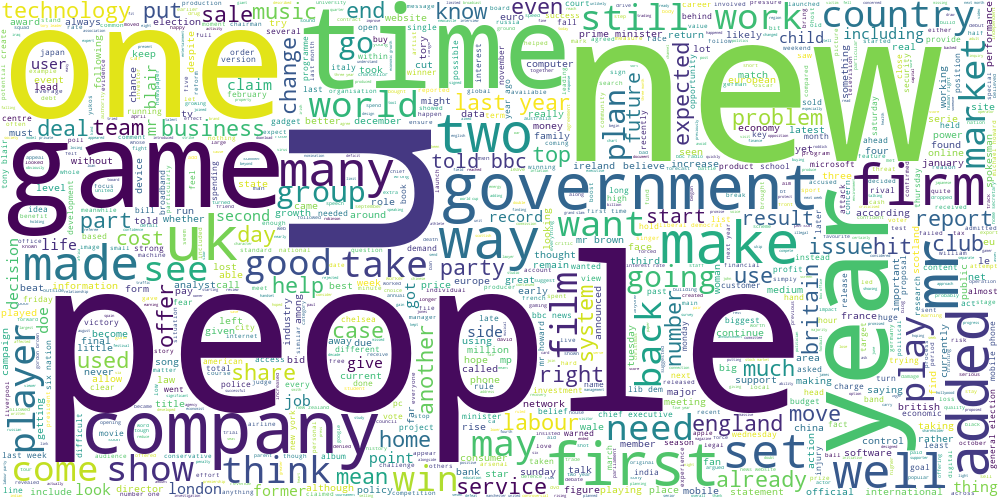

In [9]:
draw_wordcloud(data.text)

**Задание 1 (3 балла).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении [tf-idf векторайзера](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:** Да темы получились интепретируемыми, ниже приведены облака для выделенных кластеров и названия соответсвующих кластеров.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [11]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

X = vectorizer.fit_transform(data['text'])

In [12]:
X.shape

(2225, 6248)

In [13]:
kmeans = KMeans(n_clusters=6, n_init='auto', random_state=5555)

In [14]:
kmeans.fit(X)

KMeans(n_clusters=6, n_init='auto', random_state=5555)

In [15]:
kmeans_cl = kmeans.labels_

In [16]:
data['cluster'] = kmeans_cl

In [17]:
text_by_clusters = data.groupby('cluster')['text'].apply(lambda x: x.values).values

## Cluster 0 ~ Computer technologies

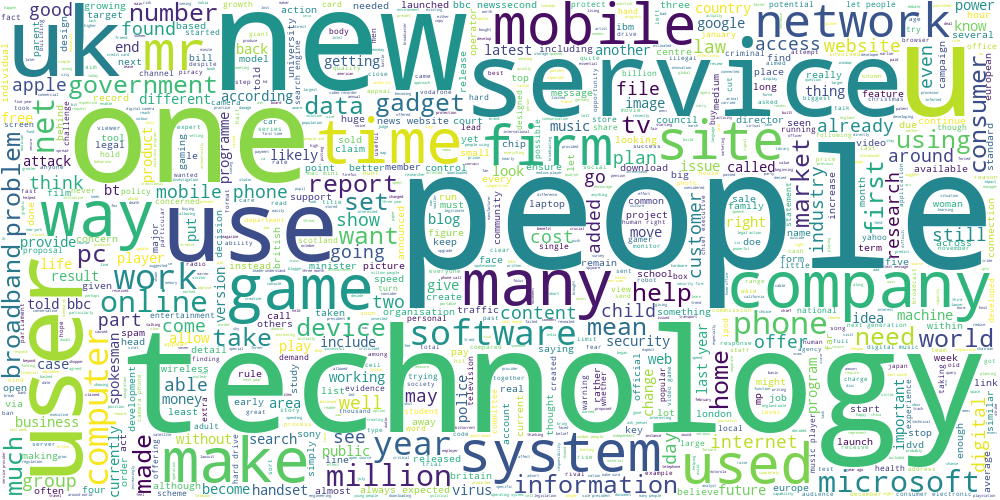

In [18]:
draw_wordcloud(text_by_clusters[0])

## Cluster 1 ~ Politics

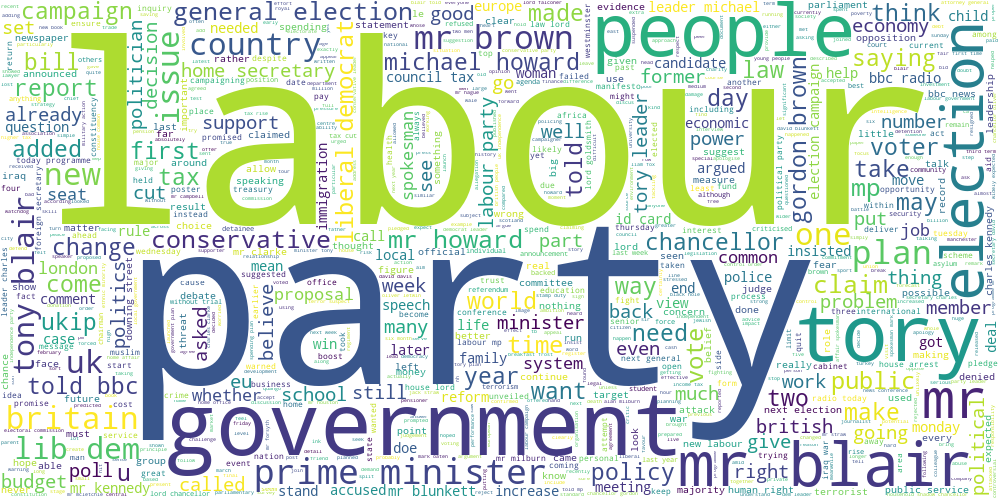

In [19]:
draw_wordcloud(text_by_clusters[1])

## Cluster 2 ~ Business

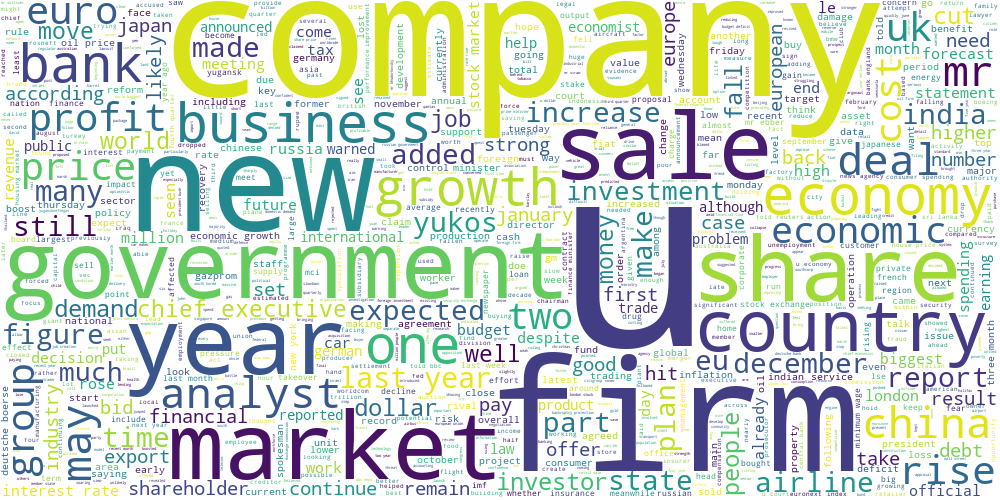

In [20]:
draw_wordcloud(text_by_clusters[2])

## Cluster 3 ~ Sport

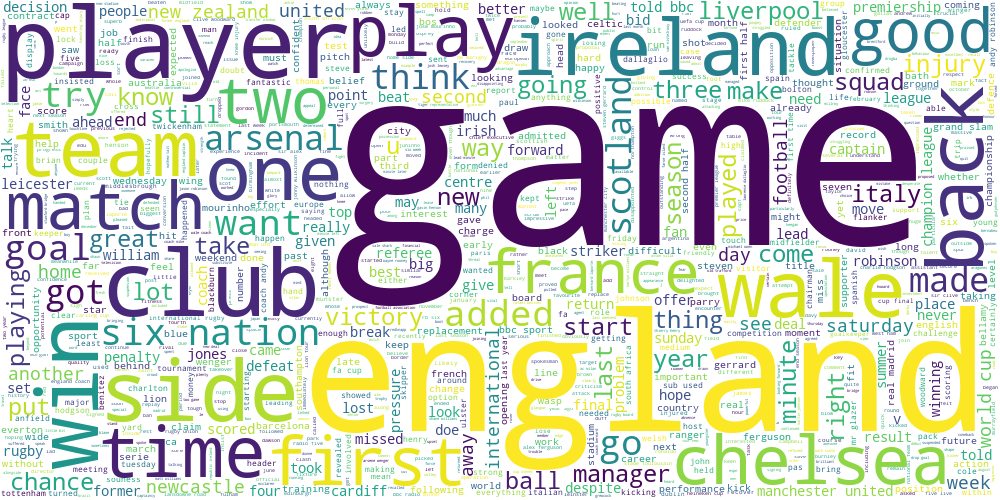

In [21]:
draw_wordcloud(text_by_clusters[3])

## Cluster 4 ~ Entartainment

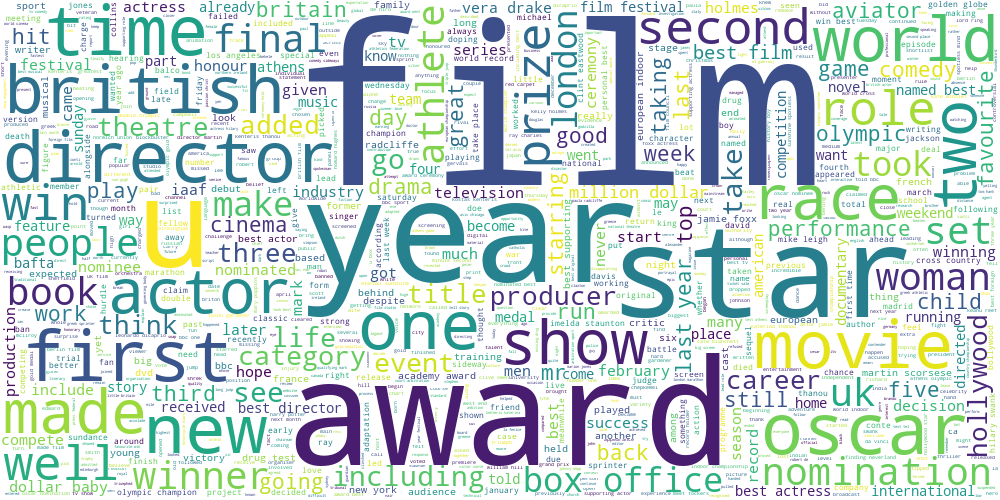

In [22]:
draw_wordcloud(text_by_clusters[4])

## Cluster 5 ~ Entertaiment

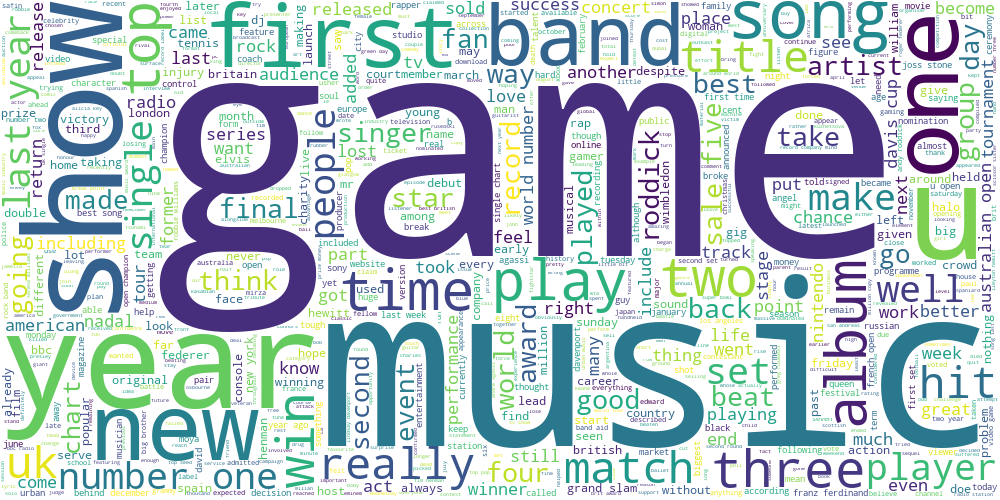

In [23]:
draw_wordcloud(text_by_clusters[5])

**Задание 2 (3 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:** Да, ключевые слова совпали, ниже приведены названия ключевых слов из исходных данных, признаки текстов которых, близки к центроидам кластеров.

In [24]:
centroids = kmeans.cluster_centers_

In [25]:
idx = []

for i in range(6):
    idx.append(np.argmin(np.apply_along_axis(lambda x: np.sqrt(np.sum((centroids[i] - x)**2)), 1, X.toarray())))

In [26]:
idx

[1916, 1151, 110, 1670, 835, 771]

In [27]:
data['category'][idx]

1916             tech
1151         politics
110          business
1670            sport
835     entertainment
771     entertainment
Name: category, dtype: object

**Задание 3 (4 балла).** Сравним три разных алгоритма кластеризации на наших текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов **K-Means**, **DBSCAN** и **спектральной кластеризации** (воспользуйтесь реализациями из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE

plt.style.use('ggplot')

In [29]:
# dbscan = DBSCAN(eps=0.65, min_samples=3).fit(X)
dbscan = DBSCAN(eps=1.215, min_samples=10).fit(X)

In [30]:
pd.Series(dbscan.labels_).value_counts()

 0    1104
-1     720
 5     123
 3      97
 6      81
 4      77
 1      13
 2      10
dtype: int64

In [31]:
dbscan_cl = dbscan.labels_

In [32]:
spectral = SpectralClustering(n_clusters=6, random_state=5555).fit(X)

In [33]:
spec_cl = spectral.labels_

In [34]:
idx_minus_one = np.where(dbscan_cl == -1)[0]
idx_others = np.setdiff1d(np.arange(len(dbscan_cl)), idx_minus_one)

## Visualisation

In [35]:
tsne = TSNE(n_components=2, init='random')

emb = tsne.fit_transform(X)

In [36]:
import matplotlib.gridspec as gridspec

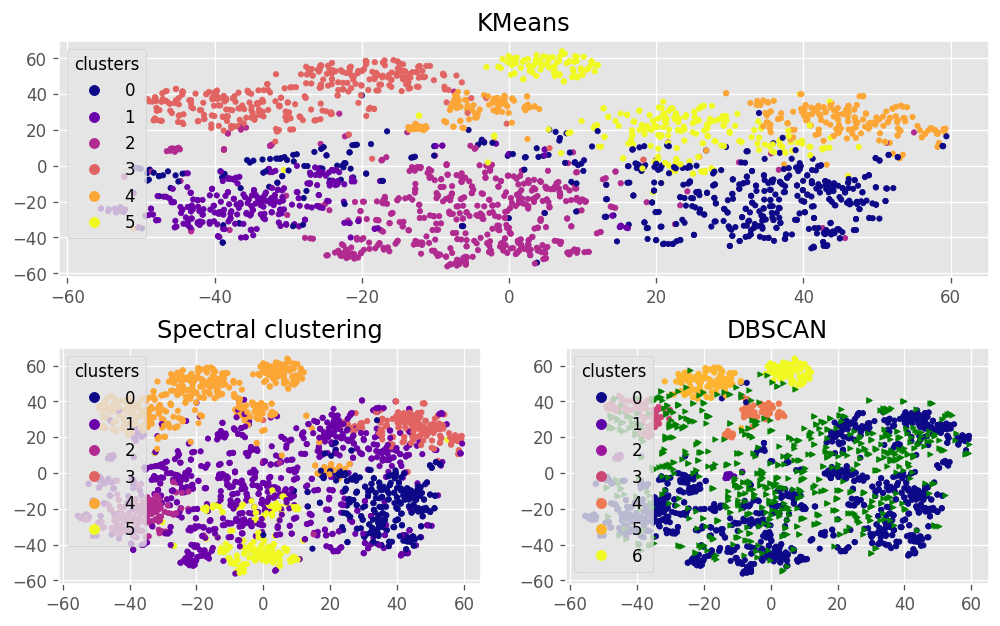

In [37]:
plt.figure(figsize=(10, 6), dpi=120)
G = gridspec.GridSpec(2, 2)

axs1 = plt.subplot(G[0, :])
axs2 = plt.subplot(G[1, 0])
axs3 = plt.subplot(G[1, 1])

sc = axs1.scatter(emb[:, 0], emb[:, 1], c=kmeans_cl, cmap=plt.cm.plasma, label=kmeans_cl, s=10)
axs1.set_title('KMeans')
axs1.legend(*sc.legend_elements(), title='clusters')

sc2 = axs2.scatter(emb[:, 0], emb[:, 1], c=spec_cl, cmap=plt.cm.plasma, s=10)
axs2.set_title('Spectral clustering')
axs2.legend(*sc2.legend_elements(), title='clusters')

emb_db = emb[idx_others]
emb_db_mo = emb[idx_minus_one]

sc3 = axs3.scatter(emb_db[:, 0], emb_db[:, 1], c=dbscan_cl[idx_others], cmap=plt.cm.plasma, s=10)
axs3.scatter(emb_db_mo[:, 0], emb_db_mo[:, 1], c='green', s=10, marker='>')

axs3.set_title('DBSCAN')
axs3.legend(*sc3.legend_elements(), title='clusters')


plt.subplots_adjust(hspace=0.3)
plt.show()